In [71]:
%load_ext autoreload
%autoreload 2

In [72]:
%reload_ext autoreload

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import keras
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.utils import class_weight
import graphviz
import pydot
import sys

In [2]:
import warnings
warnings.filterwarnings('always')

In [3]:
sys.path.insert(0, '..')
from data_wrangling import create_new_folder
from modeling_results import *
from cnn_model import *
from resnet50 import *

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [4]:
train = r'../train_images'
val = r'../val_images'
test = r'../test_images'

## INITIALIZE GENERATORS FOR TRAIN, VALIDATION, AND TEST SETS

In [5]:
image_size = (200, 200) #(height, width)
batch_size = 32
num_classes = len(os.listdir(train))

train_gen = ImageDataGenerator(rescale=1./255, 
                               shear_range=0.1,
                               zoom_range=0.1, 
                               horizontal_flip=True, 
                               fill_mode='nearest'
                              )

val_gen = ImageDataGenerator(rescale=1./255)

test_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_gen.flow_from_directory(directory=train, 
                                              target_size=image_size,
                                              color_mode='rgb',
                                              class_mode='categorical', 
                                              batch_size = batch_size,
                                              seed=42)

validation_generator = val_gen.flow_from_directory(directory=val, 
                                                   target_size=image_size,
                                                   color_mode='rgb',
                                                   class_mode='categorical', 
                                                   batch_size = batch_size,
                                                   seed=42)

test_generator = test_gen.flow_from_directory(directory=test, 
                                              target_size=image_size,
                                              color_mode='rgb',
                                              class_mode='categorical', 
                                              batch_size = 1,
                                              shuffle = False,
                                                   seed=42)

Found 1351 images belonging to 6 classes.
Found 206 images belonging to 6 classes.
Found 230 images belonging to 6 classes.


#### PREVIEW TRAIN DATASET

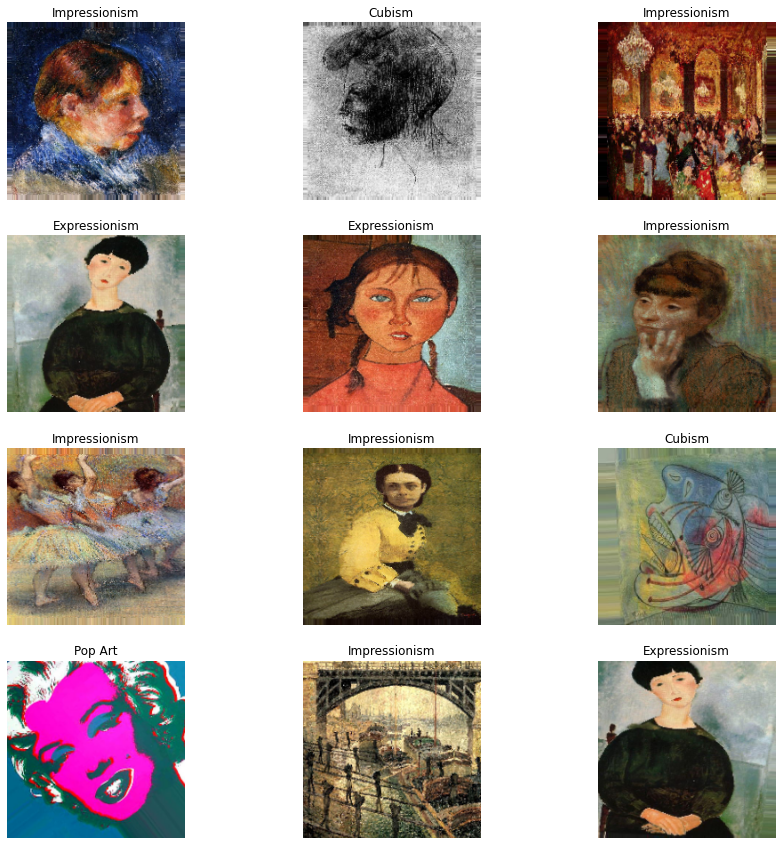

In [63]:
plt.figure(figsize=(15,15))

x, y = train_generator.__getitem__(10) #returns batch of size 32; arg is a random sequence of the batch
x = x.reshape((1,)+x.shape)
labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
y = [np.argmax(i) for i in y]
y = [labels[k] for k in y]

for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    image = x[0][i]
    plt.imshow(image)
    plt.title(y[i])
    plt.axis("off")

In [16]:
modelpath = r'../models'
epochs = 25

# CNN MODEL

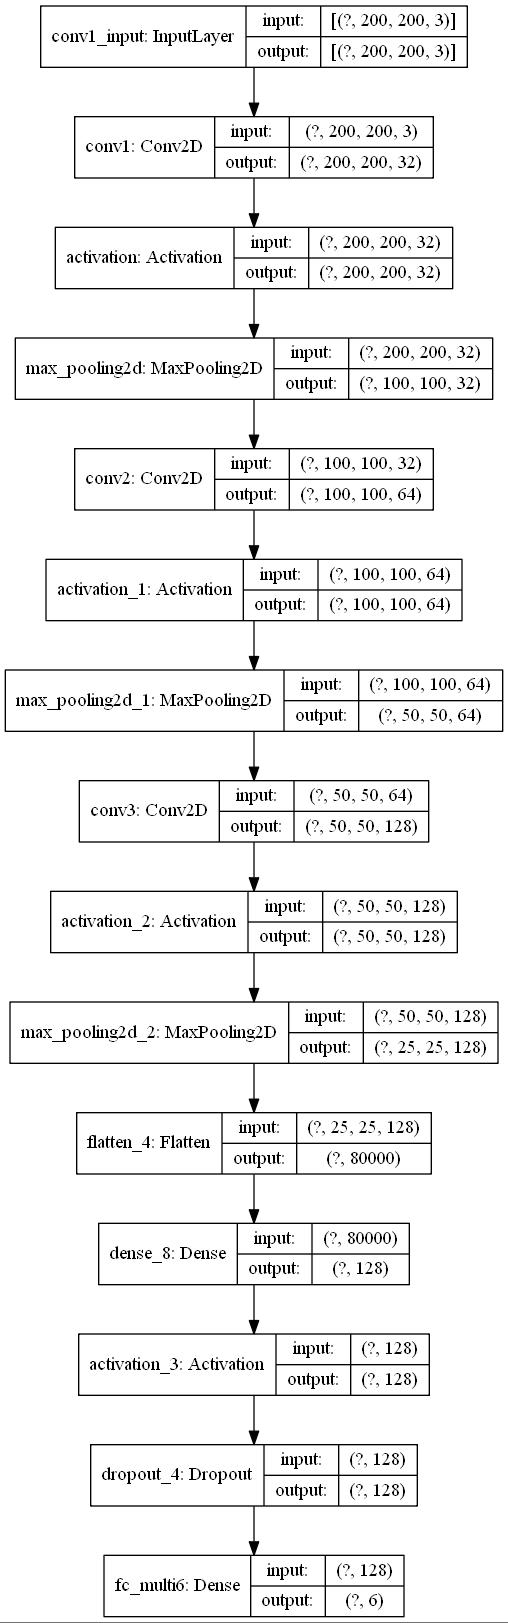

In [57]:
model = cnn_model(input_shape=image_size + (3,), num_classes=num_classes)
keras.utils.plot_model(model, to_file='../results/images/cnn_model.jpg', show_shapes=True)

In [58]:
model.load_weights('../models/model_cnn_checkpoint_25.h5')

In [46]:
callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(modelpath,f'model_cnn_checkpoint_{epochs}.h5')),]

model.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=['accuracy']
                 )

cnn_history = model.fit(train_generator,
              epochs=epochs,
              callbacks=callbacks,
              validation_data=validation_generator,)

Epoch 1/25
43/43 [==============================] - 70s 2s/step - loss: 0.6156 - accuracy: 0.7861 - val_loss: 0.8551 - val_accuracy: 0.7718
Epoch 2/25
43/43 [==============================] - 68s 2s/step - loss: 0.4417 - accuracy: 0.8386 - val_loss: 0.8278 - val_accuracy: 0.7524
Epoch 3/25
43/43 [==============================] - 67s 2s/step - loss: 0.4401 - accuracy: 0.8438 - val_loss: 0.6744 - val_accuracy: 0.8350
Epoch 4/25
43/43 [==============================] - 71s 2s/step - loss: 0.4320 - accuracy: 0.8379 - val_loss: 0.5367 - val_accuracy: 0.8350
Epoch 5/25
43/43 [==============================] - 69s 2s/step - loss: 0.4120 - accuracy: 0.8446 - val_loss: 0.6532 - val_accuracy: 0.8204
Epoch 6/25
43/43 [==============================] - 69s 2s/step - loss: 0.3909 - accuracy: 0.8594 - val_loss: 0.6402 - val_accuracy: 0.8301
Epoch 7/25
43/43 [==============================] - 69s 2s/step - loss: 0.3705 - accuracy: 0.8675 - val_loss: 0.7491 - val_accuracy: 0.8058
Epoch 8/25
43/43 [==

In [32]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 200, 200, 32)      896       
_________________________________________________________________
activation_106 (Activation)  (None, 200, 200, 32)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
conv2 (Conv2D)               (None, 100, 100, 64)      18496     
_________________________________________________________________
activation_107 (Activation)  (None, 100, 100, 64)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 50, 50, 128)      

#### SAVE METRICS AND PREDICTION RESULTS

In [47]:
#Save train/val accuracy and train/val loss
cnn_hist = pd.DataFrame(cnn_history.history)
cnn_hist.to_csv(f'../results/cnn_hist_{epochs}epochs.csv', index=False)

In [48]:
model.evaluate(validation_generator)

7/7 [==============================] - 4s 516ms/step - loss: 0.6273 - accuracy: 0.8350


[0.6273383498191833, 0.8349514603614807]

230/230 [==============================] - 5s 24ms/step


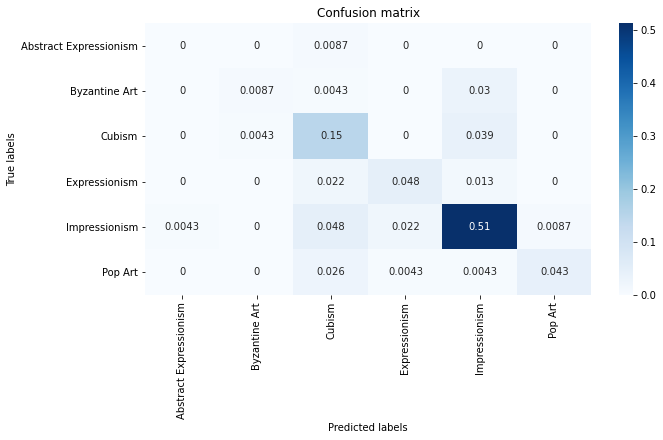

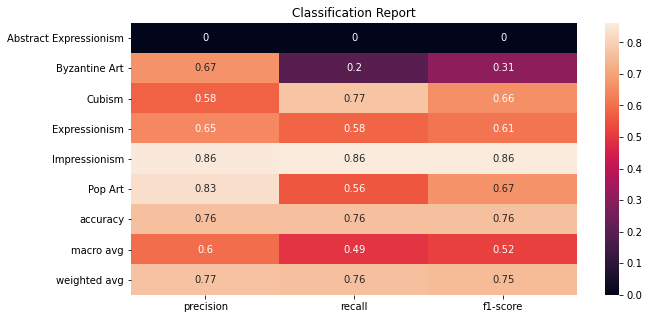

,precision,recall,f1-score,support
Abstract Expressionism,0.000000,0.000000,0.000000,2.00000
Byzantine Art,0.666667,0.200000,0.307692,10.00000
Cubism,0.576271,0.772727,0.660194,44.00000
Expressionism,0.647059,0.578947,0.611111,19.00000
Impressionism,0.855072,0.861314,0.858182,137.00000
Pop Art,0.833333,0.555556,0.666667,18.00000
accuracy,0.760870,0.760870,0.760870,0.76087
macro avg,0.596400,0.494757,0.517308,230.00000
weighted avg,0.767225,0.760870,0.753511,230.00000


In [59]:
test_generator.reset()
pred = model.predict(test_generator, verbose=1)
results = pred_results(train_generator, test_generator, pred, 'cnn_pred_results')
metric_eval(test_generator, pred, results, labels=os.listdir(train))    

# WEIGHTED CNN MODEL

In [74]:
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(train_generator.labels), y=train_generator.labels)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [60]:
wmodel = cnn_model(input_shape=image_size + (3,), num_classes=num_classes)

In [61]:
wmodel.load_weights('../models/model_cnnweighted_checkpoint_25.h5')

In [76]:
callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(modelpath,f'model_cnnweighted_checkpoint_{epochs}.h5')),]

wmodel.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=['accuracy']
                 )

weight_cnn_history = wmodel.fit(train_generator, 
                                epochs=epochs, 
                                callbacks=callbacks, 
                                validation_data=validation_generator, 
                                class_weight=class_weights)

Epoch 1/25
43/43 [==============================] - 69s 2s/step - loss: 1.9358 - accuracy: 0.1887 - val_loss: 1.7800 - val_accuracy: 0.1117
Epoch 2/25
43/43 [==============================] - 71s 2s/step - loss: 1.6987 - accuracy: 0.1976 - val_loss: 1.6978 - val_accuracy: 0.2184
Epoch 3/25
43/43 [==============================] - 68s 2s/step - loss: 1.6179 - accuracy: 0.2487 - val_loss: 1.6139 - val_accuracy: 0.2961
Epoch 4/25
43/43 [==============================] - 66s 2s/step - loss: 1.5753 - accuracy: 0.2724 - val_loss: 1.4946 - val_accuracy: 0.4126
Epoch 5/25
43/43 [==============================] - 65s 2s/step - loss: 1.4146 - accuracy: 0.3790 - val_loss: 1.7993 - val_accuracy: 0.2379
Epoch 6/25
43/43 [==============================] - 65s 2s/step - loss: 1.4803 - accuracy: 0.3597 - val_loss: 1.5537 - val_accuracy: 0.3010
Epoch 7/25
43/43 [==============================] - 65s 2s/step - loss: 1.2695 - accuracy: 0.4071 - val_loss: 1.7958 - val_accuracy: 0.3495
Epoch 8/25
43/43 [==

In [78]:
#Save train/val accuracy and train/val loss
weight_cnn_hist = pd.DataFrame(weight_cnn_history.history)
weight_cnn_hist.to_csv(f'../results/weight_cnn_hist_{epochs}epochs.csv', index=False)

In [79]:
wmodel.evaluate(validation_generator)

7/7 [==============================] - 4s 511ms/step - loss: 1.0130 - accuracy: 0.7039


[1.0130125284194946, 0.7038834691047668]

#### SAVE METRICS AND PREDICTION RESULTS

230/230 [==============================] - 6s 25ms/step


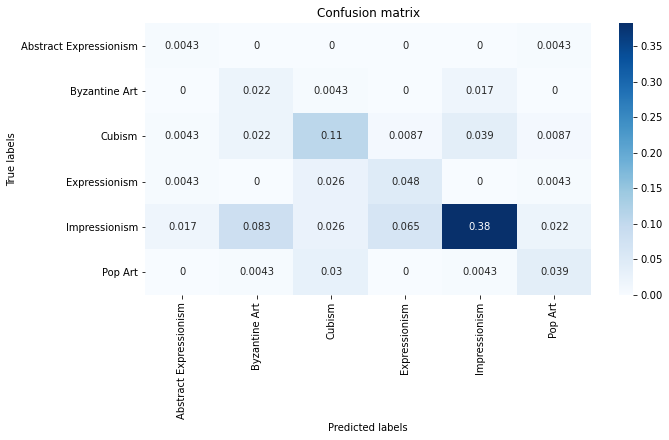

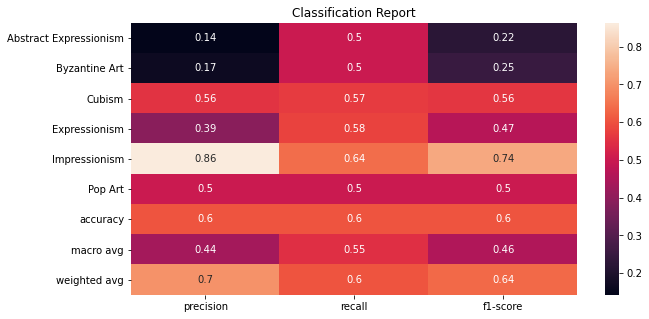

,precision,recall,f1-score,support
Abstract Expressionism,0.142857,0.500000,0.222222,2.000000
Byzantine Art,0.166667,0.500000,0.250000,10.000000
Cubism,0.555556,0.568182,0.561798,44.000000
Expressionism,0.392857,0.578947,0.468085,19.000000
Impressionism,0.862745,0.642336,0.736402,137.000000
Pop Art,0.500000,0.500000,0.500000,18.000000
accuracy,0.604348,0.604348,0.604348,0.604348
macro avg,0.436780,0.548244,0.456418,230.000000
weighted avg,0.700249,0.604348,0.636714,230.000000


In [62]:
test_generator.reset()
pred = wmodel.predict(test_generator, verbose=1)
results = pred_results(train_generator, test_generator, pred, 'cnn_model_pred_weighted_results')
metric_eval(test_generator, pred, results, labels=os.listdir(train))  

# RESNET50 MODEL

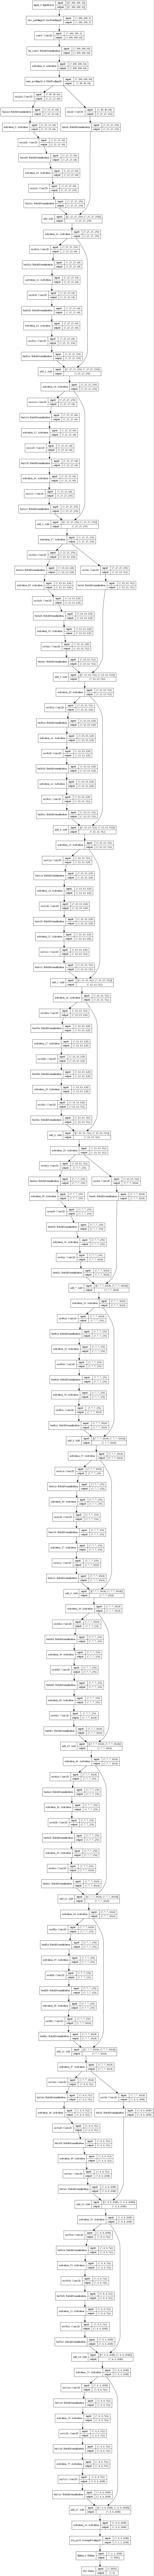

In [63]:
resnet50model = resnet50_model(input_shape=image_size+(3,), num_classes=num_classes)
keras.utils.plot_model(resnet50model, to_file='../results/images/resnet50_model.jpg', show_shapes=True)

In [64]:
resnet50model.load_weights('../models/model_resnet50weighted_checkpoint_25.h5')

In [84]:
callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(modelpath,f'model_resnet50_checkpoint_{epochs}.h5')),]

resnet50model.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=['accuracy']
                 )

r50_history = resnet50model.fit(train_generator,
                                  epochs=epochs,
                                  callbacks=callbacks,
                                  validation_data=validation_generator,
                                  batch_size=batch_size)

Epoch 1/25
43/43 [==============================] - 206s 5s/step - loss: 3.5932 - accuracy: 0.4730 - val_loss: 1.4042 - val_accuracy: 0.5971
Epoch 2/25
43/43 [==============================] - 203s 5s/step - loss: 2.4593 - accuracy: 0.5396 - val_loss: 1.2302 - val_accuracy: 0.5971
Epoch 3/25
43/43 [==============================] - 209s 5s/step - loss: 2.2061 - accuracy: 0.5352 - val_loss: 1.3170 - val_accuracy: 0.5971
Epoch 4/25
43/43 [==============================] - 214s 5s/step - loss: 1.8025 - accuracy: 0.5759 - val_loss: 1.6091 - val_accuracy: 0.5971
Epoch 5/25
43/43 [==============================] - 201s 5s/step - loss: 1.4173 - accuracy: 0.6070 - val_loss: 1.3852 - val_accuracy: 0.5971
Epoch 6/25
43/43 [==============================] - 202s 5s/step - loss: 1.3251 - accuracy: 0.5825 - val_loss: 1.9934 - val_accuracy: 0.5971
Epoch 7/25
43/43 [==============================] - 205s 5s/step - loss: 1.3504 - accuracy: 0.6107 - val_loss: 1.4815 - val_accuracy: 0.5971
Epoch 8/25
43

In [85]:
print(resnet50model.summary())

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 100, 100, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 100, 100, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [86]:
#Save train/val accuracy and train/val loss
r50_hist = pd.DataFrame(r50_history.history)
r50_hist.to_csv(f'../results/r50_hist_{epochs}epochs.csv', index=False)

In [87]:
resnet50model.evaluate(validation_generator)

7/7 [==============================] - 4s 625ms/step - loss: 5.9593 - accuracy: 0.5388


[5.959331035614014, 0.5388349294662476]

#### SAVE METRICS AND PREDICTION RESULTS

230/230 [==============================] - 9s 39ms/step


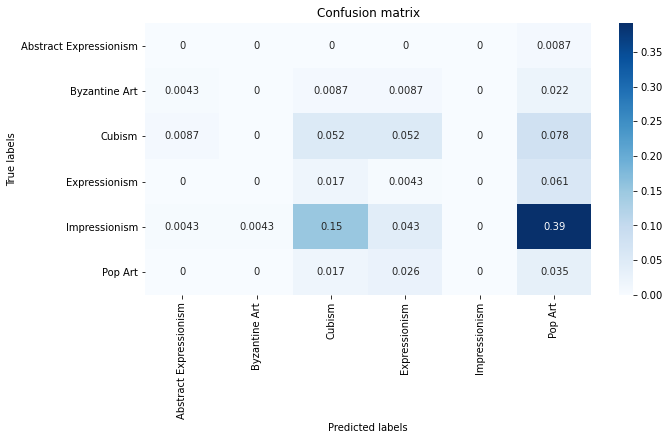

C:\Users\Justine\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justine\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justine\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

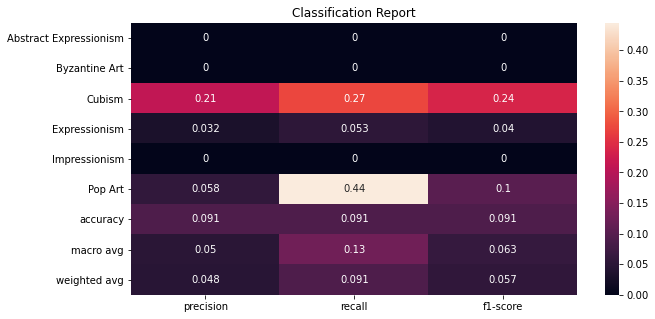

,precision,recall,f1-score,support
Abstract Expressionism,0.000000,0.000000,0.000000,2.000000
Byzantine Art,0.000000,0.000000,0.000000,10.000000
Cubism,0.210526,0.272727,0.237624,44.000000
Expressionism,0.032258,0.052632,0.040000,19.000000
Impressionism,0.000000,0.000000,0.000000,137.000000
Pop Art,0.058394,0.444444,0.103226,18.000000
accuracy,0.091304,0.091304,0.091304,0.091304
macro avg,0.050196,0.128301,0.063475,230.000000
weighted avg,0.047509,0.091304,0.056841,230.000000


In [65]:
test_generator.reset()
rn50pred = resnet50model.predict(test_generator, verbose=1)
results = pred_results(train_generator, test_generator, rn50pred, 'resnet50_model_results')
metric_eval(test_generator, rn50pred, results, labels=os.listdir(train))

# RESNET50 WEIGHTED MODEL

In [66]:
r50wmodel = resnet50_model(input_shape=image_size+(3,), num_classes=num_classes)

In [67]:
r50wmodel.load_weights('../models/model_resnet50_checkpoint_25.h5')

In [93]:
#this uses class weights
callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(modelpath,f'model_resnet50weighted_checkpoint_{epochs}.h5')),]

r50wmodel.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=['accuracy']
                 )

r50weight_history = r50wmodel.fit(train_generator,
                  epochs=epochs,
                  callbacks=callbacks,
                  validation_data=validation_generator,
                  class_weight=class_weights)

Epoch 1/25
43/43 [==============================] - 203s 5s/step - loss: 8.6885 - accuracy: 0.2443 - val_loss: 1.5741 - val_accuracy: 0.5971
Epoch 2/25
43/43 [==============================] - 202s 5s/step - loss: 2.8075 - accuracy: 0.2524 - val_loss: 24.3090 - val_accuracy: 0.3398
Epoch 3/25
43/43 [==============================] - 202s 5s/step - loss: 2.7931 - accuracy: 0.2709 - val_loss: 4684.5034 - val_accuracy: 0.0097
Epoch 4/25
43/43 [==============================] - 202s 5s/step - loss: 2.5425 - accuracy: 0.2435 - val_loss: 1767.9150 - val_accuracy: 0.0388
Epoch 5/25
43/43 [==============================] - 212s 5s/step - loss: 1.8276 - accuracy: 0.3087 - val_loss: 2.3390 - val_accuracy: 0.5971
Epoch 6/25
43/43 [==============================] - 214s 5s/step - loss: 1.7163 - accuracy: 0.3649 - val_loss: 12.4065 - val_accuracy: 0.1068
Epoch 7/25
43/43 [==============================] - 211s 5s/step - loss: 2.0480 - accuracy: 0.2798 - val_loss: 311.4183 - val_accuracy: 0.3544
Epo

In [95]:
#Save train/val accuracy and train/val loss
r50w_hist = pd.DataFrame(r50weight_history.history)
r50w_hist.to_csv(f'../results/r50_weight_hist_{epochs}epochs.csv', index=False)

In [96]:
r50wmodel.evaluate(validation_generator, verbose=1) 

7/7 [==============================] - 5s 668ms/step - loss: 6.5135 - accuracy: 0.1262


[6.513483047485352, 0.12621359527111053]

#### SAVE METRICS AND PREDICTION RESULTS

230/230 [==============================] - 9s 40ms/step


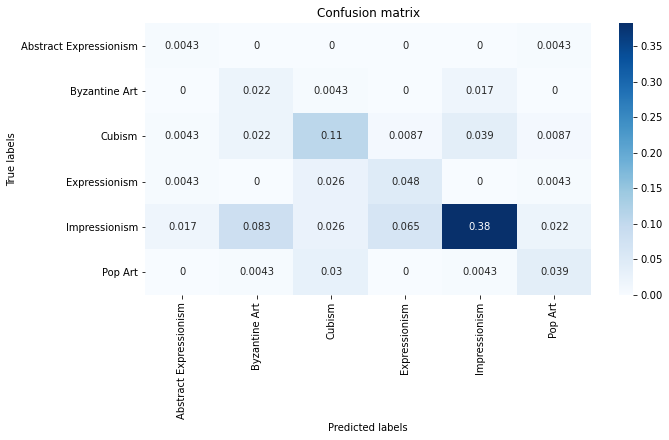

C:\Users\Justine\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justine\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justine\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

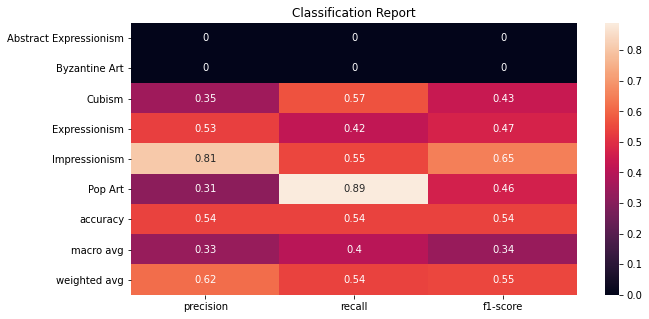

,precision,recall,f1-score,support
Abstract Expressionism,0.000000,0.000000,0.000000,2.00000
Byzantine Art,0.000000,0.000000,0.000000,10.00000
Cubism,0.352113,0.568182,0.434783,44.00000
Expressionism,0.533333,0.421053,0.470588,19.00000
Impressionism,0.806452,0.547445,0.652174,137.00000
Pop Art,0.313725,0.888889,0.463768,18.00000
accuracy,0.539130,0.539130,0.539130,0.53913
macro avg,0.334271,0.404261,0.336885,230.00000
weighted avg,0.616336,0.539130,0.546814,230.00000


In [68]:
test_generator.reset()
r50wpred = r50wmodel.predict(test_generator, verbose=1)
results = pred_results(train_generator, test_generator, pred, 'resnet50_model_weighted_results')
metric_eval(test_generator, r50wpred, results, labels=os.listdir(train))

# TRANSFER LEARNING RESNET50 with ImageNet

In [6]:
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras.optimizers import Adam

In [7]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=image_size+(3,))

x = base_model.output
x = Flatten()(base_model.output) #last_output
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)                  

x = Dense (num_classes, activation='softmax')(x)           

transfer_model = Model(inputs=base_model.input, outputs=x)

In [8]:
transfer_model.load_weights('../models/r50_transfer_checkpoint_25.h5')

We will continue to use the ADAM optimizer with a lower learning rate

In [17]:
transfer_model.compile(optimizer=Adam(lr=0.00001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(modelpath,f'r50_transfer_checkpoint_{epochs}.h5')),]

history = transfer_model.fit(train_generator, 
                    epochs=epochs,
                    callbacks=callbacks, 
                    validation_data=validation_generator,
                    batch_size=batch_size)

Epoch 1/25
43/43 [==============================] - 612s 14s/step - loss: 1.9920 - accuracy: 0.4944 - val_loss: 3.6130 - val_accuracy: 0.0777
Epoch 2/25
43/43 [==============================] - 583s 14s/step - loss: 0.9110 - accuracy: 0.7010 - val_loss: 7.5556 - val_accuracy: 0.0777
Epoch 3/25
43/43 [==============================] - 589s 14s/step - loss: 0.6521 - accuracy: 0.7809 - val_loss: 13.7616 - val_accuracy: 0.0777
Epoch 4/25
43/43 [==============================] - 660s 15s/step - loss: 0.4810 - accuracy: 0.8394 - val_loss: 12.3204 - val_accuracy: 0.0777
Epoch 5/25
43/43 [==============================] - 695s 16s/step - loss: 0.3534 - accuracy: 0.8779 - val_loss: 15.2492 - val_accuracy: 0.0777
Epoch 6/25
43/43 [==============================] - 646s 15s/step - loss: 0.2988 - accuracy: 0.8912 - val_loss: 13.3256 - val_accuracy: 0.0777
Epoch 7/25
43/43 [==============================] - 659s 15s/step - loss: 0.2308 - accuracy: 0.9127 - val_loss: 13.6401 - val_accuracy: 0.0777
E

In [18]:
#Save train/val accuracy and train/val loss
r50_transfer_hist = pd.DataFrame(history.history)
r50_transfer_hist.to_csv(f'../results/r50_transfer_hist_{epochs}epochs.csv', index=False)

In [9]:
test_generator.reset()
r50tpred = transfer_model.predict(test_generator, verbose=1)
results = pred_results(train_generator, test_generator, r50tpred, 'r50transfer_model_results')

230/230 [==============================] - 22s 94ms/step


C:\Users\Justine\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justine\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justine\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

,precision,recall,f1-score,support
Abstract Expressionism,0.000000,0.000000,0.000000,2.000000
Byzantine Art,0.470588,0.800000,0.592593,10.000000
Cubism,0.775510,0.863636,0.817204,44.000000
Expressionism,0.833333,0.526316,0.645161,19.000000
Impressionism,0.940299,0.919708,0.929889,137.000000
Pop Art,0.944444,0.944444,0.944444,18.000000
accuracy,0.865217,0.865217,0.865217,0.865217
macro avg,0.660696,0.675684,0.654882,230.000000
weighted avg,0.871663,0.865217,0.863199,230.000000


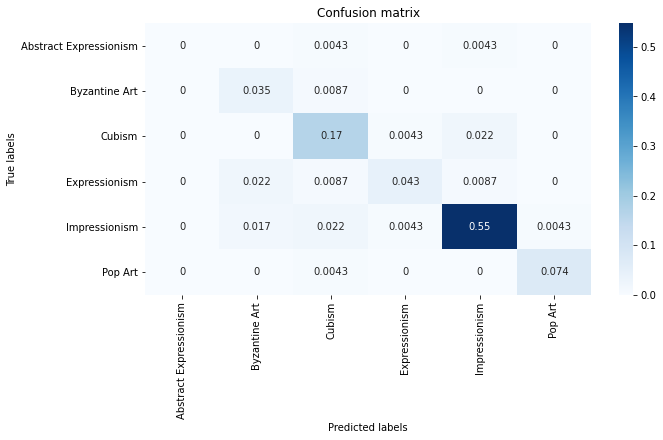

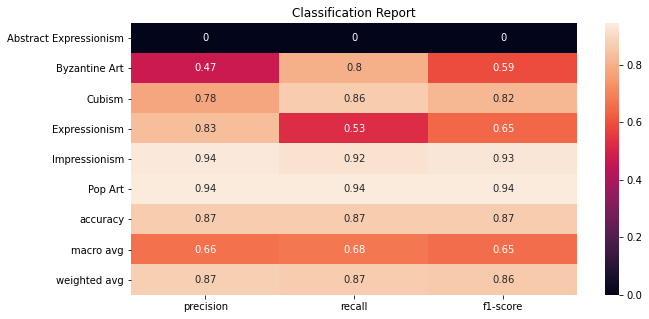

In [28]:
metric_eval(test_generator, r50tpred, results, labels=os.listdir(train))

# RESULTS

In [19]:
# LOAD ALL MODEL RESULTS BY EPOCH
cnn_df = pd.read_csv('../results/cnn_hist_25epochs.csv')
cnnw_df = pd.read_csv('../results/weight_cnn_hist_25epochs.csv')
r50_df = pd.read_csv('../results/r50_hist_25epochs.csv')
r50w_df = pd.read_csv('../results/r50_weight_hist_25epochs.csv')
r50t_df = pd.read_csv('../results/r50_transfer_hist_25epochs.csv')

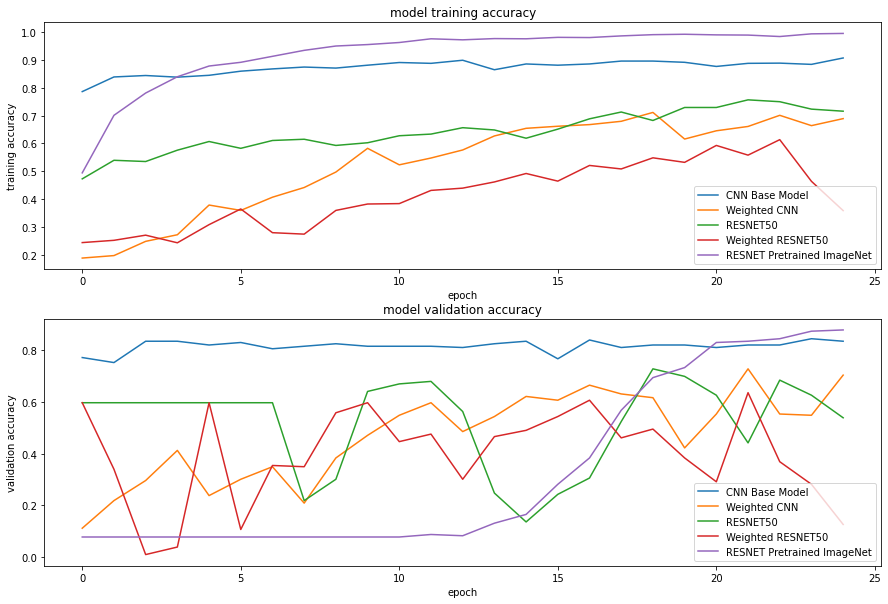

In [33]:
# PLOT AND COMPARE ACCURACY

plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.plot(cnn_df['accuracy'])
plt.plot(cnnw_df['accuracy'])
plt.plot(r50_df['accuracy'])
plt.plot(r50w_df['accuracy'])
plt.plot(r50t_df['accuracy'])
plt.title('model training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['CNN Base Model', 'Weighted CNN', 'RESNET50', 'Weighted RESNET50', 'RESNET Pretrained ImageNet'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(cnn_df['val_accuracy'])
plt.plot(cnnw_df['val_accuracy'])
plt.plot(r50_df['val_accuracy'])
plt.plot(r50w_df['val_accuracy'])
plt.plot(r50t_df['val_accuracy'])
plt.title('model validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['CNN Base Model', 'Weighted CNN', 'RESNET50', 'Weighted RESNET50', 'RESNET Pretrained ImageNet'], loc='lower right')

plt.savefig(f'../results/images/train_val_accuracy.jpg', bbox_inches='tight')

# BEST METRICS: PRE-TRAINED RESNET50

C:\Users\Justine\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justine\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justine\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

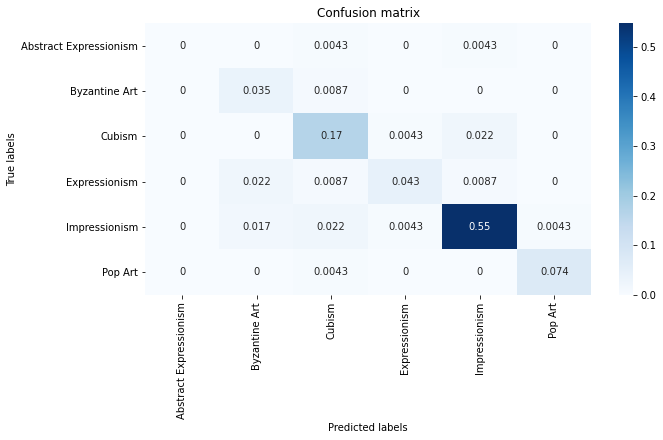

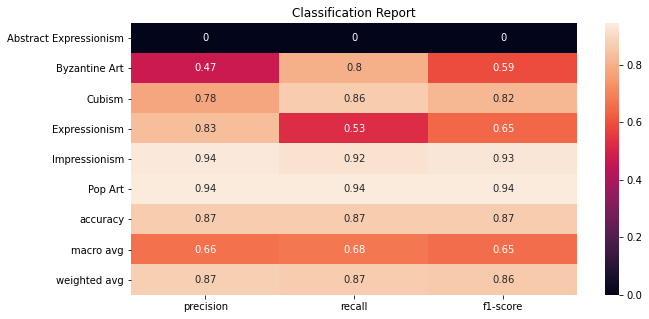

In [29]:
cm = confusion_matrix(list(results.True_Label), list(results.Predictions), labels=os.listdir(train))
plot_confusion_matrix(cm, os.listdir(train))
plt.savefig(f'../results/images/transfer_confusion_matrix.jpg', bbox_inches='tight')
cf = cf_report(test_generator, r50tpred, os.listdir(train))
plot_clf(cf)
plt.savefig(f'../results/images/transfer_classification_heatmap.jpg', bbox_inches='tight')